In [1]:
import requests
import os
from IPython.display import JSON
import pandas as pd
import numpy as np
import time

from wordcloud import WordCloud, STOPWORDS
import plotly.express as px

import panel as pn
pn.extension()
import param
import hvplot.pandas

import pickle
from io import StringIO

In [2]:
APIKEY = os.environ.get('ASSEMBLYAI_APIKEY')

## Upload file

In [16]:
# filename = "Audio/Dolly Shuts Down Patronising Interview In Style.mp4"
# def read_file(filename, chunk_size=5242880):
#     with open(filename, 'rb') as _file:
#         while True:
#             data = _file.read(chunk_size)
#             if not data:
#                 break
#             yield data

# headers = {'authorization': APIKEY}
# response = requests.post('https://api.assemblyai.com/v2/upload',
#                         headers=headers,
#                         data=read_file(filename))

# audio_url = response.json()['upload_url']

## Submit for Transcription

In [15]:
# endpoint = "https://api.assemblyai.com/v2/transcript"
# json = {
#     "audio_url": audio_url,
#     "speaker_labels":True,
#     "auto_highlights": True,
#     "sentiment_analysis":True,
#     "iab_categories":True
    
# }
# headers = {
#     "authorization": APIKEY,
#     "content-type": "application/json"
# }
# response = requests.post(endpoint, json=json, headers=headers)
# print(response.json())

## Get Transcription Result

In [13]:
# result_endpoint = f'{endpoint}/{response.json()["id"]}'
# headers_auth = {
#     "authorization": APIKEY,
# }
# transcript_response = requests.get(result_endpoint, headers=headers_auth)
# print(transcript_response.json())

# while response.json()['status'] != "completed":
#     response = requests.get(result_endpoint, headers=headers_auth)
#     time.sleep(5)

In [29]:
for u in transcript_response.json()['sentiment_analysis_results']:
    if u['sentiment'] == 'NEGATIVE':
        print(u)

{'text': 'If you had of it would have been something very natural but I would have probably kicked your shins or something.', 'start': 5307, 'end': 10550, 'sentiment': 'NEGATIVE', 'confidence': 0.5358942747116089, 'speaker': 'B'}
{'text': 'They took that kind of thing from people like us.', 'start': 22555, 'end': 26992, 'sentiment': 'NEGATIVE', 'confidence': 0.6504906415939331, 'speaker': 'B'}
{'text': "My assistant asked me something and I'm going to blame it on her because I wouldn't have had the nerve otherwise.", 'start': 72262, 'end': 77172, 'sentiment': 'NEGATIVE', 'confidence': 0.5965232849121094, 'speaker': 'A'}
{'text': "Well, I can't show you.", 'start': 79762, 'end': 81217, 'sentiment': 'NEGATIVE', 'confidence': 0.5410354733467102, 'speaker': 'B'}
{'text': "I don't like to be like everybody else.", 'start': 108162, 'end': 110422, 'sentiment': 'NEGATIVE', 'confidence': 0.7588388919830322, 'speaker': 'B'}
{'text': "But do you ever feel that you're a joke?", 'start': 146887, 'e

In [14]:
JSON(transcript_response.json())

<IPython.core.display.JSON object>

In [34]:
with open('Dolly_Barbara.pkl', 'wb') as f:
    pickle.dump(response.json().copy(), f)

In [35]:
with open('Dolly_Barbara.pkl', 'rb') as f:
    data = pickle.load(f)

In [36]:
buffer = StringIO()
buffer.write(data['text'])
buffer.seek(0)

0

In [37]:
transcript_download = pn.widgets.FileDownload(file=buffer,
                                              filename="transcript.txt",
                                              button_type="success")
transcript_download

FileDownload(button_type='success', file=<_io.StringIO o..., filename='transcript.txt', label='Download transcript.txt')

In [38]:
audio_url = "https://github.com/CharlesPizza/AudioAnalysisDollyParton/blob/main/Audio/Dolly%20Shuts%20Down%20Patronising%20Interview%20In%20Style.mp3?raw=true"
audio_play = pn.pane.Audio(audio_url, name="Audio", time=360)
audio_play

Audio(str, time=360)

In [289]:
sentiment = data['sentiment_analysis_results']
sentiment_df = pd.DataFrame(sentiment)
sentiment_df['speaker'] = sentiment_df['speaker'].map(lambda x: ['Dolly' if x == 'B' else 'Barbara']).explode('speaker')

In [290]:
sentiment_df

,text,start,end,sentiment,confidence,speaker
0,Dolly where I come from.,462,2827,NEUTRAL,0.828847,Barbara
1,Would I have called you a hillbilly?,2920,5127,NEUTRAL,0.651311,Barbara
2,If you had of it would have been something ver...,5307,10550,NEGATIVE,0.535894,Dolly
3,"No, actually.",11137,11887,NEUTRAL,0.666117,Dolly
4,But when I think of your beliefs and I think o...,11950,14407,NEUTRAL,0.770856,Barbara
...,...,...,...,...,...,...
60,"See, the thing of it is you don't find a perso...",220182,224977,NEGATIVE,0.561005,Dolly
61,You are and can share the things and to plan f...,225145,229147,POSITIVE,0.832287,Dolly
62,"We have our foundation, we have our roots, we ...",229180,234672,POSITIVE,0.899541,Dolly
63,I've got better things to do than to sit aroun...,234717,238872,NEGATIVE,0.543684,Dolly


In [294]:
_df = pd.DataFrame()
_df['count'] = sentiment_df.groupby(['speaker', 'sentiment'])['sentiment'].count()
plot = _df.hvplot(title="Sentiment Analysis by Speaker", kind="bar")
pn.Row(plot)

Row
    [0] HoloViews(Bars)

In [295]:
positive_df = sentiment_df.query('sentiment == "POSITIVE"')[["text","sentiment",'speaker']]
negative_df = sentiment_df.query('sentiment == "NEGATIVE"')[['text','sentiment','speaker']]
neutral_df = sentiment_df.query('sentiment == "NEUTRAL"')[['text','sentiment','speaker']]

sentiment_tabs = pn.Tabs(('Sentiment Overview', plot),
                         ('Positive', pn.widgets.DataFrame(positive_df, autosize_mode='fit_columns', width=700, height=300)),
                         ('Negative', pn.widgets.DataFrame(negative_df, autosize_mode='fit_columns', width=700, height=300)),
                         ('Neutral', pn.widgets.DataFrame(neutral_df, autosize_mode='fit_columns', width=700, height=300))
                        )
sentiment_tabs

Tabs
    [0] HoloViews(Bars, name='Sentiment Overview')
    [1] DataFrame(autosize_mode='fit_columns', height=300, sizing_mode='fixed', value=                          ..., width=700)
    [2] DataFrame(autosize_mode='fit_columns', height=300, sizing_mode='fixed', value=                          ..., width=700)
    [3] DataFrame(autosize_mode='fit_columns', height=300, sizing_mode='fixed', value=                          ..., width=700)

In [343]:
speaker_text = sentiment_df.groupby('speaker')['text'].apply(' '.join).map(lambda x: x.lower())

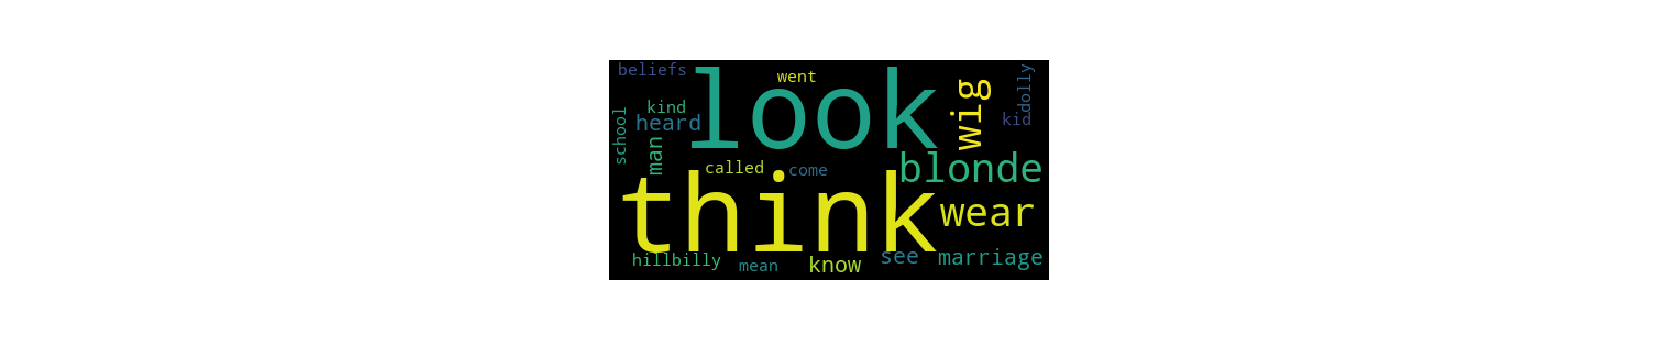

In [406]:
stopwords = set(STOPWORDS)
wordcloud_barbara = WordCloud(background_color = "black", stopwords = stopwords, max_words=20, 
                      colormap = 'viridis', collocations=False).generate(speaker_text['Barbara'])
wordcloud_plot_barb = px.imshow(wordcloud_barbara)
wordcloud_plot_barb.update_xaxes(showticklabels=False)
wordcloud_plot_barb.update_yaxes(showticklabels=False)
wordcloud_plot_barb
# word_tabs = pn.Tabs(('Overall', wordcloud_plot))
# word_tabs

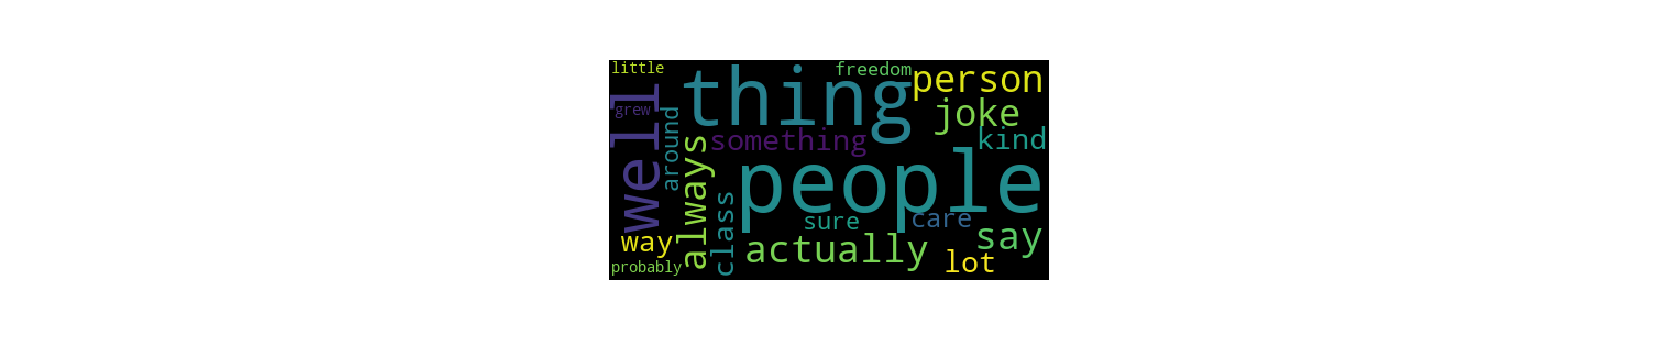

In [407]:
wordcloud_dolly = WordCloud(background_color = "black", stopwords = stopwords, max_words=20, 
                      colormap = 'viridis', collocations=False).generate(speaker_text['Dolly'])
wordcloud_plot_dolly = px.imshow(wordcloud_dolly)
wordcloud_plot_dolly.update_xaxes(showticklabels=False)
wordcloud_plot_dolly.update_yaxes(showticklabels=False)
wordcloud_plot_dolly


In [411]:
# Create interactive slider
class Controller(param.Parameterized):
    word_slider = param.Integer(30, bounds=(5, 50), step=5)

controller = Controller()

@pn.depends(controller.param.word_slider, watch=False)
def update_wordcloud(num_words):
    # Word cloud plot
    wordcloud = WordCloud(background_color='black', stopwords = stopwords, max_words = num_words,
                          colormap='viridis', collocations=False).generate(num_words)

    wordcloud_plot = px.imshow(wordcloud) 
    # Remove labels on axes
    wordcloud_plot.update_xaxes(showticklabels=False)
    wordcloud_plot.update_yaxes(showticklabels=False)
    return wordcloud_plot



<h4> We skipped AutoChapters as this audio is very short </h4>
However, as a good practice we can 

## Auto Word Highlights by Time and Rank

In [472]:
_ = pd.DataFrame(data['words'])
_['start'] = _['start'].apply(lambda x: x/100)
def f(i):
    if i == 'A':
        return "Barbara"
    else: return "Dolly"
_['speaker'] = _['speaker'].apply(f)
_.drop(['end', 'confidence'], axis=1, inplace=True)
_.rename(columns={'start':'timestamp'}, inplace=True)

In [473]:
_.head()

,text,timestamp,speaker
0,Dolly,4.62,Barbara
1,where,15.37,Barbara
2,I,19.30,Barbara
3,come,22.15,Barbara
4,from.,24.55,Barbara


In [478]:
highlights = pd.DataFrame(data['auto_highlights_result']['results'])
highlights = highlights.explode('timestamps')
highlights['timestamp'] = highlights['timestamps'].map(lambda x: x['start']/100)
highlights = pd.merge(highlights, _, how='left', on='timestamp', suffixes=('','_y')).drop(['timestamps', 'text_y'], axis=1)
highlights


,count,rank,text,timestamp,speaker
0,1,0.08,better things,2351.20,Dolly
1,1,0.07,Good common sense horse,404.67,Dolly
2,1,0.06,more jokes,1626.55,Dolly
3,4,0.06,freedom,2086.15,Dolly
4,4,0.06,freedom,2102.80,Dolly
5,4,0.06,freedom,2153.95,Barbara
6,4,0.06,freedom,2198.65,Dolly
7,1,0.05,very proud people,281.05,Dolly
8,1,0.05,country class,314.05,Dolly
9,1,0.05,Paul Dean,1968.10,Barbara


In [177]:
def gen_count_size(df):
    return df['count'].map(lambda x: x*100)

In [550]:
highlights_plot = highlights[['count', 'rank', 'text', 'timestamp', 'speaker']].hvplot.points(x="timestamp", y="rank",
              padding=0.4, hover_cols=['speaker'],
              width=1300, height=600,
              size=gen_count_size(highlights), color="text", title="Automatic Highlighted Words")# * \
# highlights.hvplot.labels(x='timestamp', y='rank', text='speaker', text_baseline='top',
#                          hover=False).opts(fontscale=1.5)

pn.Row(highlights_plot)

Row
    [0] HoloViews(Points)

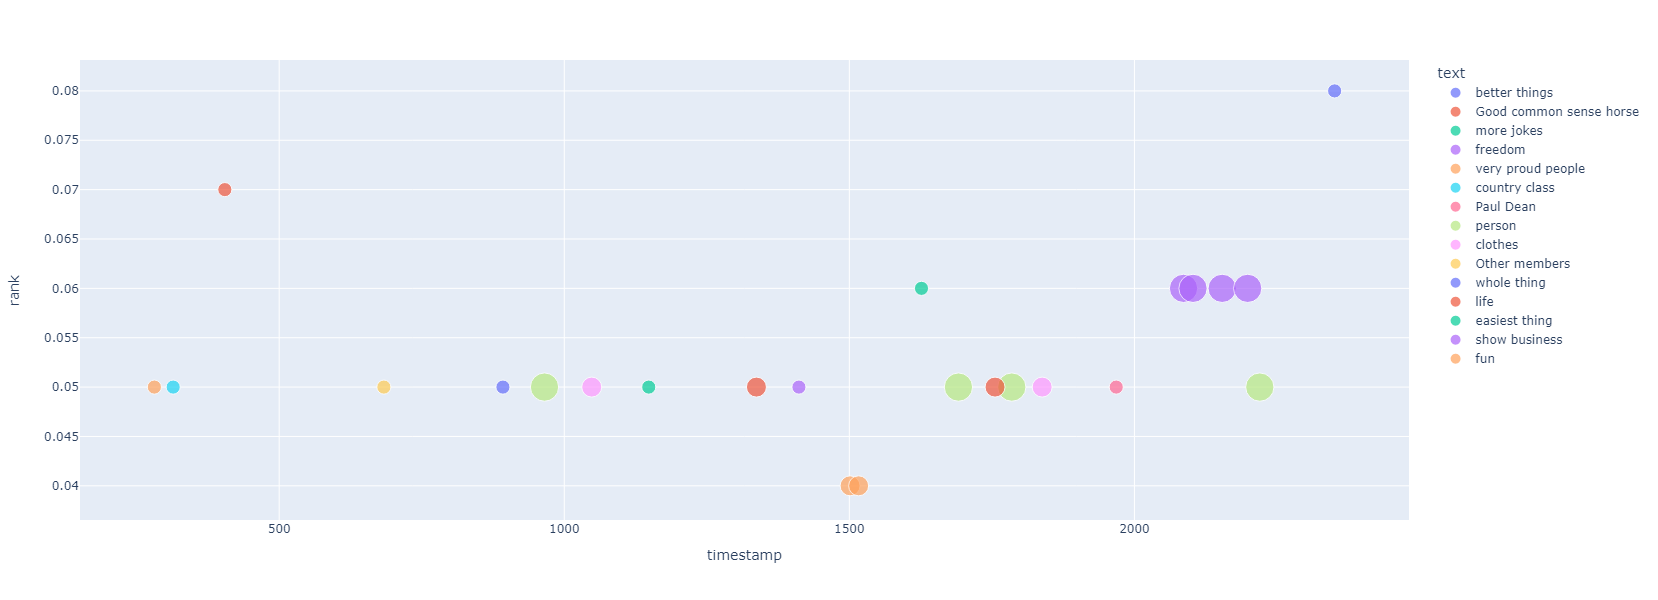

In [549]:
fig = px.scatter(data_frame=highlights, x='timestamp', y='rank', color='text', size=gen_count_size(highlights),hover_name='speaker',hover_data={'speaker':True, 'text':True, 'timestamp':True, 'count':True},height=600)
fig.update_layout(
    hoverlabel=dict(
        bgcolor="white",
        font_size=16,
        font_family="Rockwell"
    )
)
fig.show()